In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth


In [2]:
def anomaly(dato,obs):
    climatologia = obs.mean(dim='time')
    anomalia = dato.mean(dim='time') - climatologia
    return climatologia, anomalia


In [5]:
#Datos-----------------------------------------------------------------
path = '/home/tabu/Escritorio/Doctorado/ClimDinam/TP2/'
path2 = '/media/tabu/JULIAexterno/climatologia_dinamica/'

#Abro CanESM2
CanESM2_ens = xr.open_dataset(path2+'CanESM2/pr_Amon_CanESM2_historical_ensmean_197601-200512_2.5_mes.nc')

#Abro CanESM5
CanESM5_ens = xr.open_dataset(path2+'CanESM5/pr_Amon_CanESM5_historical_ensmean1p1f1_2.5_mes.nc')

In [111]:

#Monzón HS
def annual_range_HS(dato):
    verano = dato.sel(time=dato['time.season']=='DJF').mean(dim='time').pr
    invierno = dato.sel(time=dato['time.season']=='JJA').mean(dim='time').pr
    primavera = dato.sel(time=dato['time.season']=='SON').mean(dim='time').pr
    otono = dato.sel(time=dato['time.season']=='MAM').mean(dim='time').pr
    anual = verano + primavera + invierno + otono
    porcentaje_verano = verano/anual
    rango = (verano-invierno)*3
    return rango, porcentaje_verano

#Monzón HN
def annual_range_HN(dato):
    verano = dato.sel(time=dato['time.season']=='JJA').mean(dim='time').pr
    invierno = dato.sel(time=dato['time.season']=='DJF').mean(dim='time').pr
    primavera = dato.sel(time=dato['time.season']=='MAM').mean(dim='time').pr
    otono = dato.sel(time=dato['time.season']=='SON').mean(dim='time').pr
    anual = verano + primavera + invierno + otono
    porcentaje_verano = verano/anual
    rango = (verano-invierno)*3
    return rango, porcentaje_verano


In [112]:
def mapa(dato1,dato2,titulo):
    #America del sur -------Observaciones-----------------------------------------
    fig = plt.figure(figsize=(10, 18),dpi=300,constrained_layout=True)
    fig_size = plt.rcParams["figure.figsize"]
    data_crs = ccrs.PlateCarree(central_longitude=0)
    projection = ccrs.PlateCarree()
    ax1 = plt.subplot(1,1,1,projection=projection)
    #ax1.set_extent([275,335, 10, -60], crs=data_crs)
    clevels = np.arange(0,1,0.2)
    #levels1 = [dato1.min(),2,dato1.max()]
    #ax1.contourf(cyclic_lons, lat, dato1,levels1, transform=data_crs,levels=levels1, hatches=["", "..."], alpha=0.01)
    #levels2 = [dato2.min(),2,dato2.max()]
    #ax1.contourf(cyclic_lons, lat, dato2,levels2, transform=data_crs,levels=levels2, hatches=["", "..."], alpha=.01)
 
    im1=ax1.contourf(cyclic_lons, lat, dato1,clevels,transform=data_crs,cmap='Blues',extend='both')
    im2=ax1.contourf(cyclic_lons, lat, dato2,clevels,transform=data_crs,cmap='Blues',extend='both') 
    
    ax1.add_feature(cartopy.feature.COASTLINE)
    ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
    ax1.gridlines(crs=data_crs, linewidth=0.3, linestyle='-')
    #Saco las coordenadas de la figura hasta ahora
    plt0_ax = plt.gca()
    left, bottom1, width, height = plt0_ax.get_position().bounds
    first_plot_left = plt0_ax.get_position().bounds[0]
    #Utilizo las coordenadas para definir la posición de la colorbar 1
    colorbar_axes = fig.add_axes([first_plot_left + .9, bottom1, 0.02, 1.2*height])
    cbar = plt.colorbar(im1, colorbar_axes, fraction=0.05, pad=0.04,aspect=18, orientation='vertical')
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=16)
    cbar.set_label('verano [mm/mes] ',fontsize=20)
    fig_size[0] = width*4 + 10
    fig_size[1] = height*2 + 3
    plt.rcParams["figure.figsize"] = fig_size
    fig.suptitle(str(titulo), y=0.68, x=0.5,fontsize=20)
    return fig


In [125]:
mon_range_CanESM2_HS, p_verano_HS = annual_range_HS(CanESM2_ens)
monzon_range_HS = (mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)/mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)) * p_verano_HS.where(p_verano_HS > .35)

mon_range_CanESM2_HN, p_verano_HN = annual_range_HN(CanESM2_ens)
monzon_range_HN = (mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)/mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)) * p_verano_HN.where(p_verano_HN > .35)

lon = np.arange(0, 362, 362/144)
lat = CanESM2_ens.lat
cyclic_range_HN, cyclic_lons = add_cyclic_point(monzon_range_HN, coord=lon)
cyclic_range_HS, cyclic_lons = add_cyclic_point(monzon_range_HS, coord=lon)


<function matplotlib.pyplot.clf()>

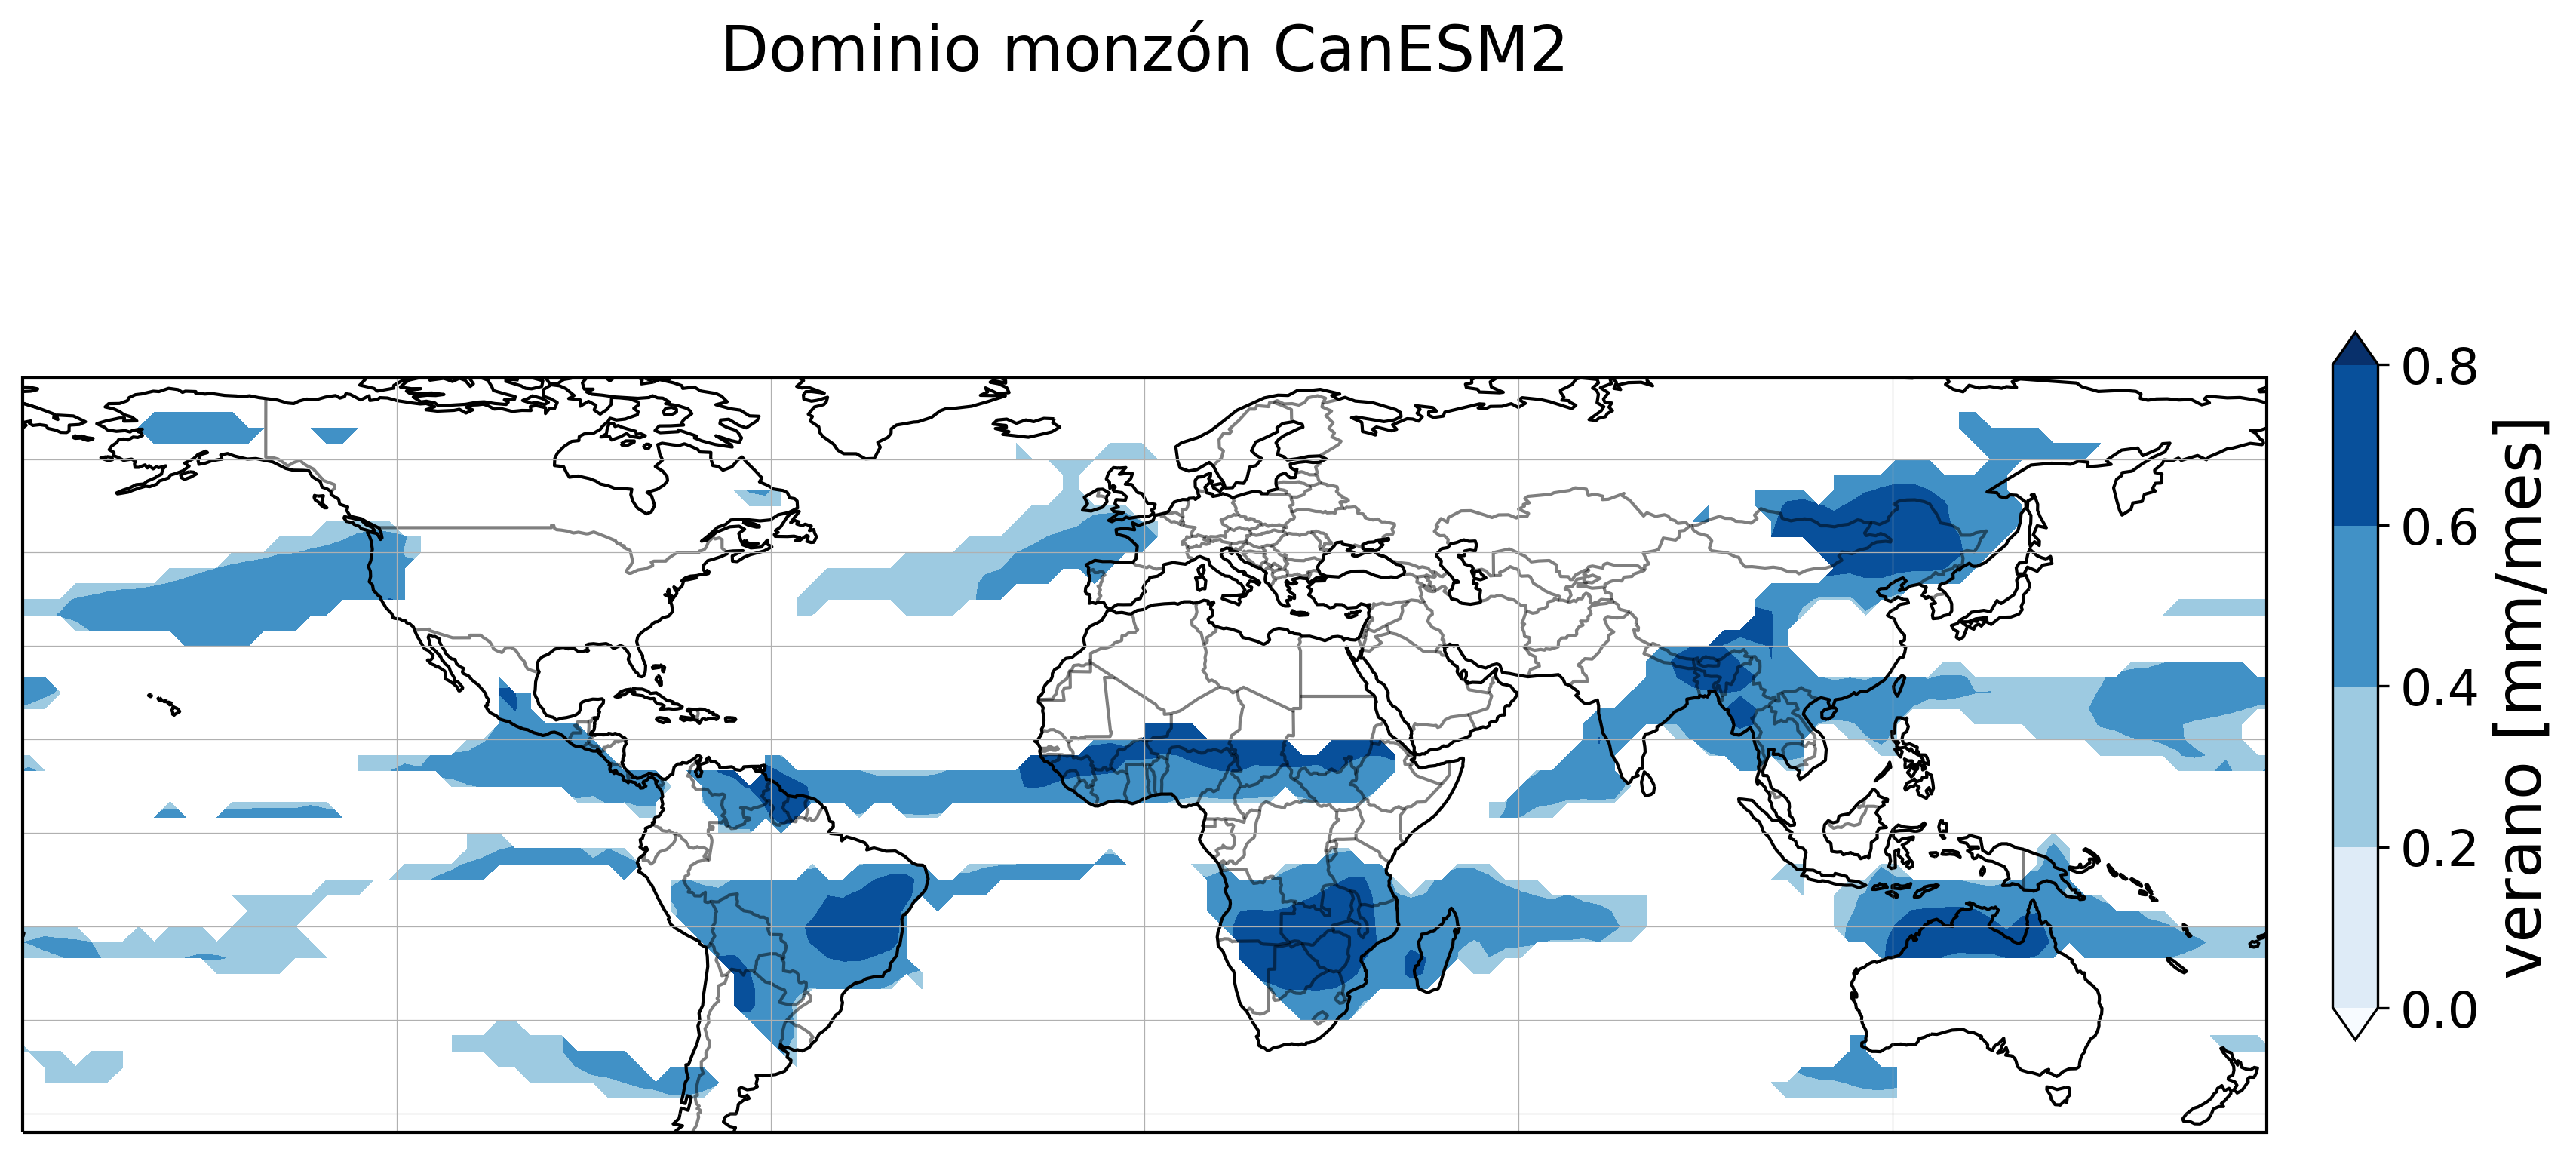

In [126]:
titulo = 'Dominio monzón CanESM2'
lat = CanESM2_ens.lat
mapa(cyclic_range_HS,cyclic_range_HN,titulo)
plt.savefig(path+'dominio_monzon_CanESM2.png',bbox_inches='tight')
plt.clf

In [127]:
monzon_mask_HS = (mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)/mon_range_CanESM2_HS.where(mon_range_CanESM2_HS > 180)) * (p_verano_HS.where(p_verano_HS > .35)/p_verano_HS.where(p_verano_HS > .35))
monzon_mask_HN = (mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)/mon_range_CanESM2_HN.where(mon_range_CanESM2_HN > 180)) * (p_verano_HN.where(p_verano_HN > .35)/p_verano_HN.where(p_verano_HN > .35))


In [122]:
#Genero un mapa para la precipitacion 
def mapa_colores(dato1,dato2,titulo):
    #America del sur -------Observaciones-----------------------------------------
    fig = plt.figure(figsize=(10, 18),dpi=300,constrained_layout=True)
    fig_size = plt.rcParams["figure.figsize"]
    data_crs = ccrs.PlateCarree(central_longitude=0)
    projection = ccrs.PlateCarree()
    ax1 = plt.subplot(1,1,1,projection=projection)
    #ax1.set_extent([275,335, 10, -60], crs=data_crs)
    clevels = np.arange(0,700,50)
    im1=ax1.contourf(cyclic_lons, lat, dato1,clevels,transform=data_crs,cmap='Blues',extend='both')
    im2=ax1.contourf(cyclic_lons, lat, dato2,clevels,transform=data_crs,cmap='Blues',extend='both')
    ax1.add_feature(cartopy.feature.COASTLINE)
    ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
    ax1.gridlines(crs=data_crs, linewidth=0.3, linestyle='-')
    #ax1.set_title('Annual range')
    #Saco las coordenadas de la figura hasta ahora
    plt0_ax = plt.gca()
    left, bottom1, width, height = plt0_ax.get_position().bounds
    first_plot_left = plt0_ax.get_position().bounds[0]
    #Utilizo las coordenadas para definir la posición de la colorbar 1
    colorbar_axes = fig.add_axes([first_plot_left + .9, bottom1, 0.02, 1.2*height])
    fig_size[0] = width*4 + 10
    fig_size[1] = height*2 + 3
    plt.rcParams["figure.figsize"] = fig_size
    fig.suptitle(str(titulo), y=0.62, x=0.5,fontsize=20)
    cbar = plt.colorbar(im2, colorbar_axes, fraction=0.05, pad=0.04,aspect=18, orientation='vertical')
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=16)
    cbar.set_label('verano [mm/mes] ',fontsize=20)
    return fig


In [120]:
HS_monson = CanESM2_ens.pr*monzon_mask_HS
HS = HS_monson.sel(time=HS_monson['time.season']=='DJF').mean(dim='time')
cyclic_data_HS, cyclic_lons = add_cyclic_point(HS, coord=lon)
HN_monson = CanESM2_ens.pr*monzon_mask_HN
HN = HN_monson.sel(time=HN_monson['time.season']=='JJA').mean(dim='time')

/home/tabu/anaconda3/envs/juliapy/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tabu/anaconda3/envs/juliapy/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


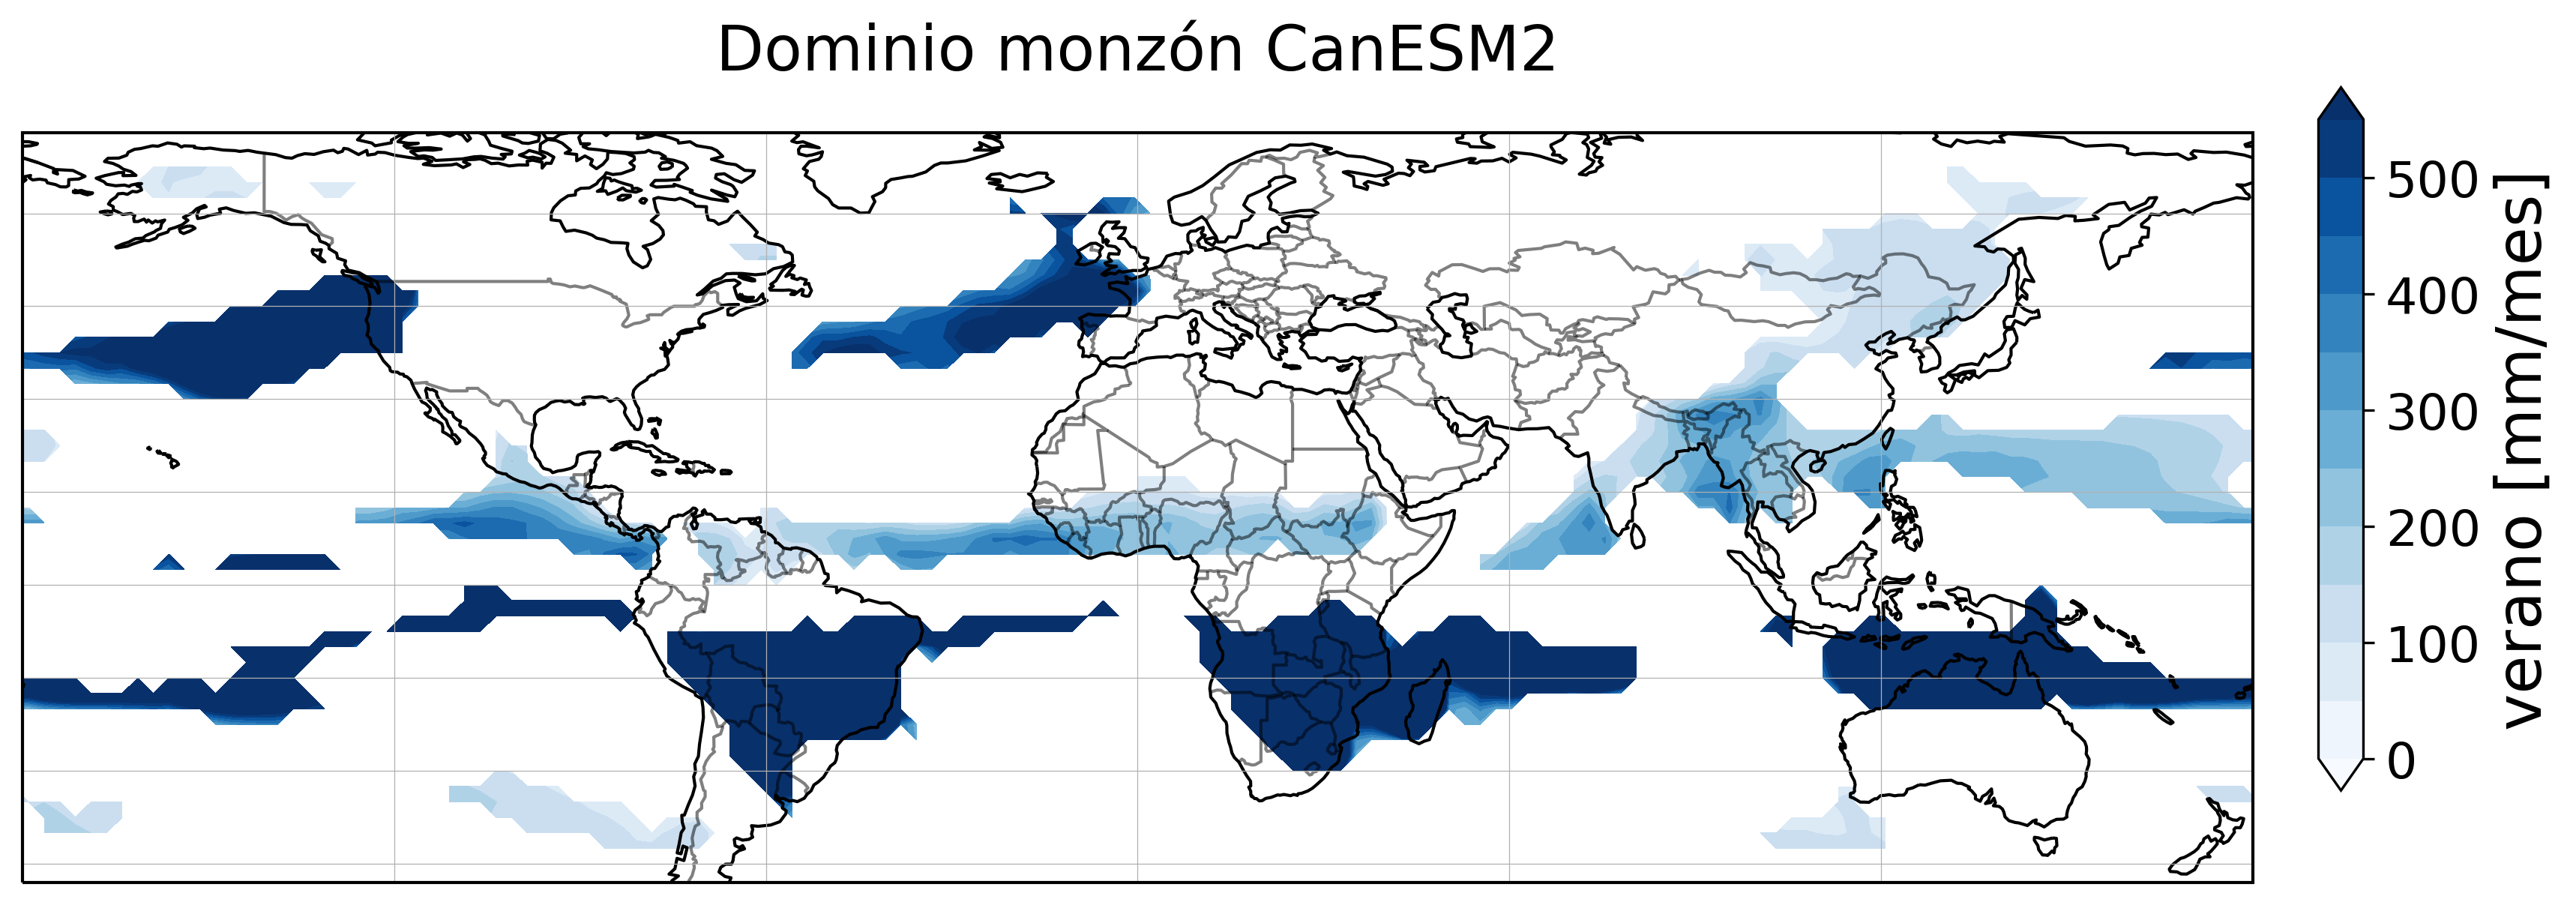

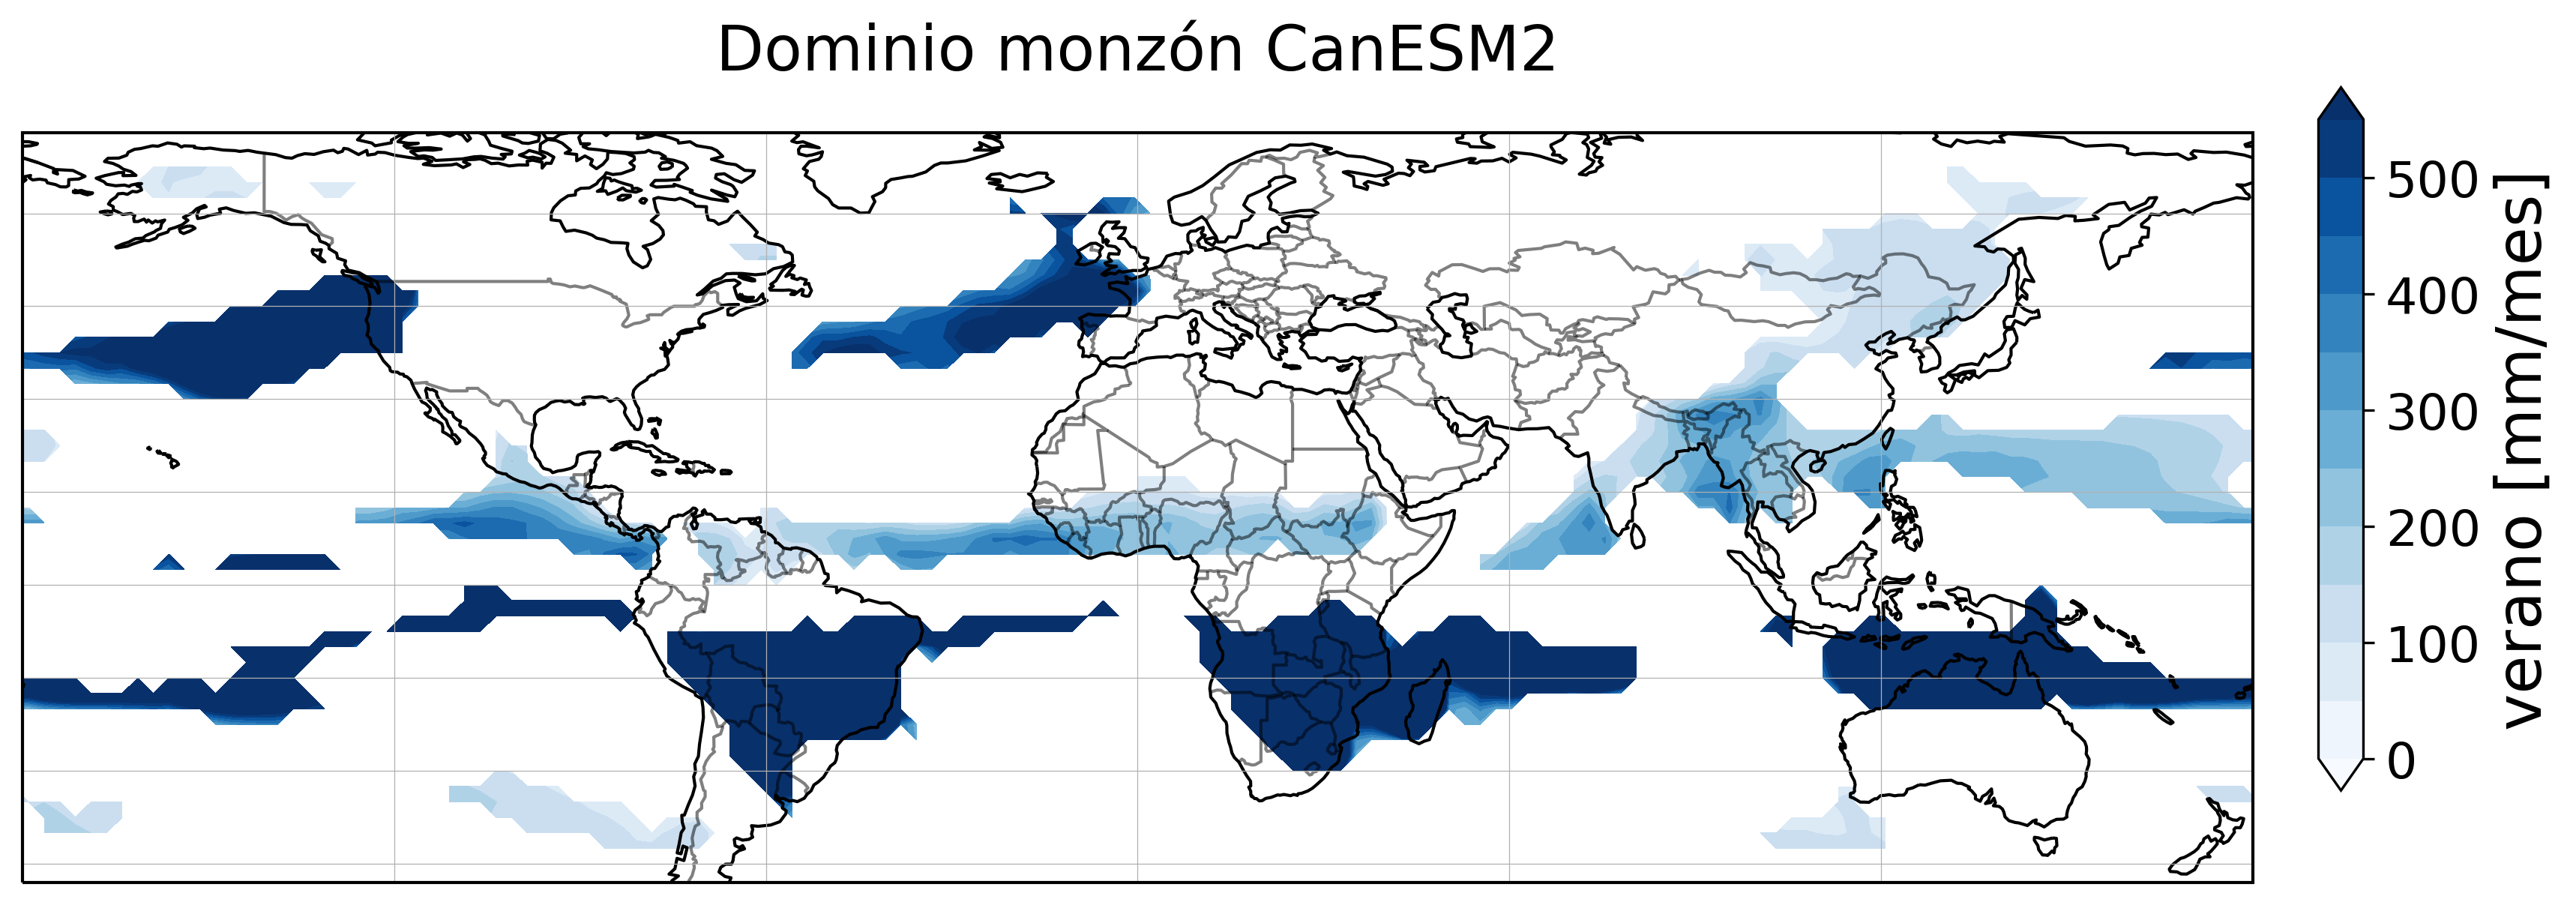

In [123]:
cyclic_data_HN, cyclic_lons = add_cyclic_point(HN, coord=lon)
mapa_colores(cyclic_data_HS,cyclic_data_HN,titulo)

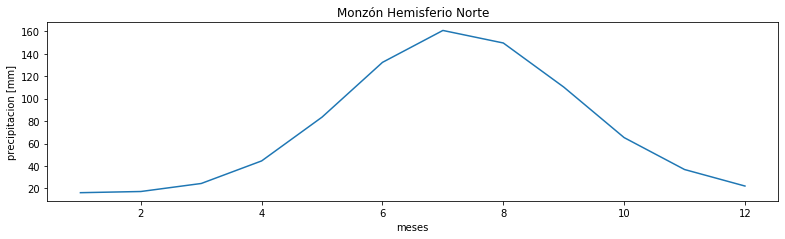

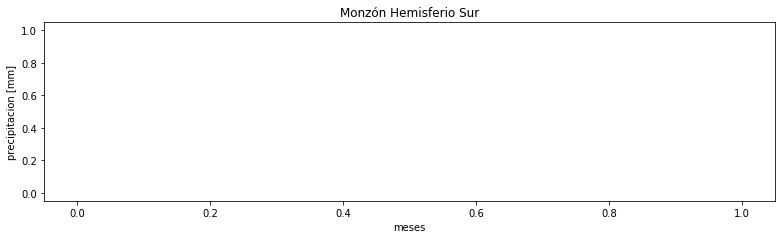

In [110]:

#Calculo el ciclo anual
monson_HS = HS_monson.mean(dim='lon').mean(dim='lat').groupby("time.month").mean("time")
monson_HN = HN_monson.mean(dim='lon').mean(dim='lat').groupby("time.month").mean("time")
meses = monson_HN.month
plt.plot(meses,monson_HN)
plt.xlabel('meses')
plt.ylabel('precipitacion [mm]')
plt.title('Monzón Hemisferio Norte')
#plt.savefig(path+'ciclo_anual_HN_CanESM2.png',bbox_inches='tight')
plt.show()
plt.plot(meses,monson_HS)
plt.xlabel('meses')
plt.ylabel('precipitacion [mm]')
plt.title('Monzón Hemisferio Sur')
#plt.savefig(path+'ciclo_anual_HS_CanESM2.png',bbox_inches='tight')
plt.show()
